In [2]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import importlib

import ATARI.utils.hdf5 as h5io

from copy import copy
from ATARI.theory.resonance_statistics import make_res_par_avg

from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator
from ATARI.ModelData.experimental_model import Experimental_Model
from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.particle import Particle, Neutron, Ta181

from ATARI.PiTFAll import fnorm


In [3]:
sammypath = ''
assert(sammypath != '')

In [4]:
%matplotlib widget

In [5]:
Ta181 = Particle(Z=73, A=181, I=3.5, mass=180.94803, name='Ta181')
Ta_pair = Particle_Pair(isotope = "Ta181",
                        resonance_ladder = pd.DataFrame(),
                        formalism = "XCT",
                        energy_range = [200,250],
                        ac = 0.8127,
                        target=Ta181,
                        projectile=Neutron,
                        l_max = 1
)

# print quant number map up to l_max
Ta_pair.map_quantum_numbers(print_out=True)

# J = 3, <D> = 9.0030 eV, <gn2> = 452.56615 meV, <gg2> = 32.0 meV
# J = 4, <D> = 8.3031 eV, <gn2> = 332.24347 meV, <gg2> = 32.0 meV

# add spin group information for both s-wave resonances
Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D=9.0030,
                       gn2_avg=452.56615, #46.5,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D=8.3031,
                       gn2_avg=332.24347, #35.5,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)

resonance_ladder = Ta_pair.sample_resonance_ladder()
resonance_ladder

Spin group data for all parity
(Jpi, #Chs, l-waves)
(-5.0, 1, [1])
(-4.0, 2, [1, 1])
(-3.0, 2, [1, 1])
(-2.0, 1, [1])
(3.0, 1, [0])
(4.0, 1, [0])


,E,Gg,Gn1,J_ID,gg2,gn2,Jpi,L
0,204.255474,-62.714457,15.501989,1.0,-31.357229,305.465696,3.0,0.0
1,221.390611,-61.249832,-18.840343,1.0,-30.624916,-356.591585,3.0,0.0
2,232.718009,-65.147482,-67.610727,1.0,-32.573741,-1248.137678,3.0,0.0
3,201.509968,-66.404267,-55.640246,2.0,-33.202133,-1103.831181,4.0,0.0
4,207.009903,-60.138730,0.293490,2.0,-30.069365,5.744599,4.0,0.0
5,213.429985,-66.212759,0.496916,2.0,-33.106379,9.578940,4.0,0.0
6,218.198106,64.115332,7.509613,2.0,32.057666,143.170641,4.0,0.0
7,223.263943,61.165282,-4.954538,2.0,30.582641,-93.380396,4.0,0.0
8,243.519883,62.361571,0.888568,2.0,31.180786,16.035605,4.0,0.0


### To calculate a doppler broadenned cross section without any other experimental corrections

1. Build experimental model with reaction, energy grid, and temperature you want. Also, empty the inputs for additional alphanumeric commands and Resolution function
2. Use the template generator to make a template corresponding to the experimental model you just made and inspect it - alternatively, you can use the preloaded dop_2sg.inp or dop_1sg.inp template in the ATARI.sammy_interface.sammy_templates folder
4. Run sammy without bayes 


In [6]:

theo_exp_model = Experimental_Model(
                                 title = "theo", 
                                 reaction = "elastic", 
                                 energy_range = [200, 250], 
                                 template = None, 
                                 energy_grid = np.linspace(200,250,1000), 
                                 temp = (295.0, 0.0),
                                 sammy_inputs= {"alphanumeric":[],
                                             "ResFunc": None},
                                 )
# theo_exp_model

In [8]:

rto = sammy_classes.SammyRunTimeOptions(sammypath,
                             **{"Print"   :   True,
                              "bayes"   :   False,
                              "keep_runDIR"     : True,
                              "sammy_runDIR": "sammy_runDIR_1"
                              })

template_creator.make_input_template('theo.inp',Ta_pair, theo_exp_model, rto)
theo_exp_model.template= os.path.realpath('theo.inp')

In [9]:
sammyINP = sammy_classes.SammyInputData(
    Ta_pair,
    resonance_ladder,
    template=theo_exp_model.template,
    experiment=theo_exp_model,
    energy_grid = theo_exp_model.energy_grid
)

sammyOUT = sammy_functions.run_sammy(sammyINP, rto)

In [10]:
sammyOUT.pw

,E,exp_xs,exp_xs_unc,theo_xs,theo_xs_bayes,exp_trans,exp_trans_unc,theo_trans,theo_trans_bayes
0,200.00000,1.0,1.0,3.106904,NaN,NaN,NaN,NaN,NaN
1,200.05005,1.0,1.0,3.057443,NaN,NaN,NaN,NaN,NaN
2,200.10010,1.0,1.0,3.014232,NaN,NaN,NaN,NaN,NaN
3,200.15015,1.0,1.0,2.979572,NaN,NaN,NaN,NaN,NaN
4,200.20020,1.0,1.0,2.956578,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
995,249.79980,1.0,1.0,9.320217,NaN,NaN,NaN,NaN,NaN
996,249.84985,1.0,1.0,9.317728,NaN,NaN,NaN,NaN,NaN
997,249.89990,1.0,1.0,9.315254,NaN,NaN,NaN,NaN,NaN
998,249.94995,1.0,1.0,9.312795,NaN,NaN,NaN,NaN,NaN


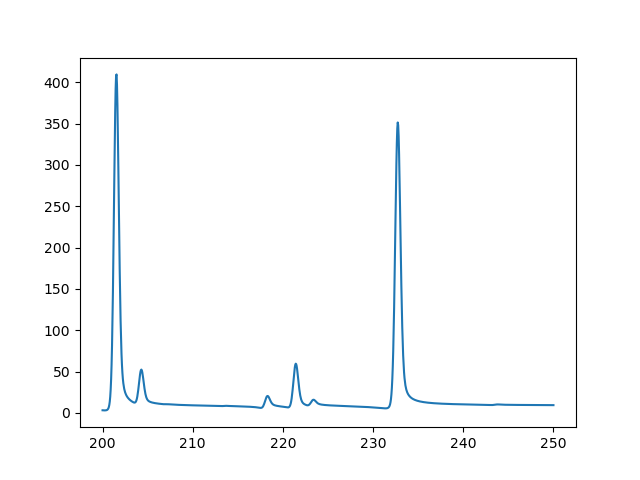

In [11]:
figure()
plot(sammyOUT.pw.E, sammyOUT.pw.theo_xs)

In [12]:
# from ATARI.PiTFAll.fnorm import calc_theo_broad_xs_for_all_reaction
# calc_theo_broad_xs_for_all_reaction('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
#                                      shell,
#                                         particle_pair, 
#                                         resonance_ladder, 
#                                         energy_range,
#                                         temperature,
#                                         target_thickness,
#                                         template, 
#                                         reactions)